In [1]:
# Importacion de Librerias
import sqlite3
import pandas as pd
import os 

In [4]:
def obtener_tablas_y_datos(conn):
    """
    Recupera todas las tablas de una base de datos SQLite y sus respectivos datos.

    Esta función ejecuta una consulta para obtener los nombres de todas las tablas
    en la base de datos y luego realiza una consulta SELECT sobre cada tabla para
    recuperar todos sus datos. Los resultados se devuelven en forma de un diccionario,
    donde las claves son los nombres de las tablas y los valores son DataFrames de pandas
    con el contenido de cada tabla.

    Parámetros:
    conn : sqlite3.Connection
        Objeto de conexión a la base de datos SQLite.

    Retorna:
    dict
        Un diccionario donde las claves son los nombres de las tablas y los valores
        son DataFrames que contienen los datos de cada tabla.
    """

    tablas_query = "SELECT name FROM sqlite_master WHERE type='table';"
    tablas = pd.read_sql_query(tablas_query, conn)['name'].tolist()
    dbs = {tabla: pd.read_sql_query(f"SELECT * FROM {tabla};", conn) for tabla in tablas}
    return dbs

In [5]:
# Conectar a las bases de datos
with sqlite3.connect('../database.sqlite') as conn1, sqlite3.connect('../database_contratos.sqlite') as conn2:
    # Obtener datos de cada base de datos
    db1 = obtener_tablas_y_datos(conn1)
    db2 = obtener_tablas_y_datos(conn2)


#Conversión de las bases de datos al formato DataFrame
db_apicall = pd.DataFrame(db1['apicall'])
db_commerce = pd.DataFrame(db1['commerce'])
db_contratos = pd.DataFrame(db2['contract'])


In [6]:
#Exploracion
print("Información Tabla Apicall")
db_apicall.info()
print("Información Tabla Commerce")
db_commerce.info()

Información Tabla Apicall
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   date_api_call  1500000 non-null  object 
 1   commerce_id    1500000 non-null  object 
 2   ask_status     1500000 non-null  object 
 3   is_related     1200495 non-null  float64
dtypes: float64(1), object(3)
memory usage: 45.8+ MB
Información Tabla Commerce
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   commerce_id      5 non-null      object
 1   commerce_nit     5 non-null      int64 
 2   commerce_name    5 non-null      object
 3   commerce_status  5 non-null      object
 4   commerce_email   5 non-null      object
dtypes: int64(1), object(4)
memory usage: 332.0+ bytes


In [7]:
# Cambiamos el formato de fecha que incluye horas al formato unicamente de fecha.
# Convertir la columna 'fecha' a datetime
db_apicall['date_api_call']  = pd.to_datetime(db_apicall['date_api_call'])

In [9]:
# Chequeando valores nulos
db_commerce.isnull().sum() , db_apicall.isnull().sum()

(commerce_id        0
 commerce_nit       0
 commerce_name      0
 commerce_status    0
 commerce_email     0
 dtype: int64,
 date_api_call         0
 commerce_id           0
 ask_status            0
 is_related       299505
 dtype: int64)

In [11]:
# Contar la frecuencia de cada categoría
db_apicall['ask_status'].value_counts()

ask_status
Successful      1200495
Unsuccessful     299505
Name: count, dtype: int64

In [18]:
db_commerce.describe() , db_apicall.describe()

(       commerce_nit
 count  5.000000e+00
 mean   4.090541e+08
 std    3.362635e+08
 min    2.896011e+07
 25%    1.988183e+08
 50%    4.454706e+08
 75%    4.526807e+08
 max    9.193410e+08,
                        date_api_call    is_related
 count                        1500000  1.200495e+06
 mean   2024-07-02 00:33:23.949236224  6.671648e-01
 min              2024-01-01 00:00:15  0.000000e+00
 25%       2024-04-01 16:45:41.500000  0.000000e+00
 50%       2024-07-01 23:32:30.500000  1.000000e+00
 75%       2024-10-01 10:41:27.500000  1.000000e+00
 max              2024-12-31 23:59:39  1.000000e+00
 std                              NaN  4.712283e-01)

In [12]:
union = db_commerce[['commerce_name','commerce_id']]

In [13]:
agrupacion = db_apicall.groupby(['commerce_id', 'ask_status']).size().unstack(fill_value=0)


In [14]:
union = pd.merge(agrupacion,db_commerce[['commerce_name','commerce_id']],on='commerce_id')

In [15]:
union.iloc[:,1:]

,Successful,Unsuccessful,commerce_name
0,240591,59921,Zenith Corp.
1,239507,60145,FusionWave Enterprises
2,240036,60064,Innovexa Solutions
3,239976,59805,QuantumLeap Inc.
4,240385,59570,NexaTech Industries


In [16]:
import matplotlib.pyplot as plt

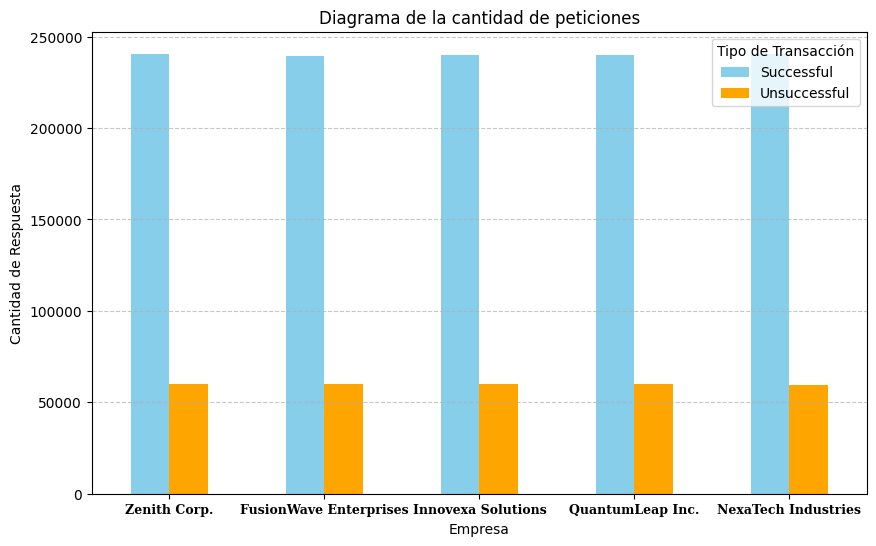

In [17]:
# Graficar
fig, ax = plt.subplots(figsize=(10, 6))
# Graficar especificando la columna para el eje X y las columnas para Y
union.plot(kind='bar', x='commerce_name',color=['skyblue', 'orange'], ax= ax)
plt.xticks(rotation= 0, fontsize=9, fontweight='bold', fontfamily='serif') 
plt.title('Diagrama de la cantidad de peticiones')
plt.xlabel('Empresa', fontsize=10)
plt.ylabel('Cantidad de Respuesta')
plt.legend(title='Tipo de Transacción')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()